A few months ago I did the [data science]() course at [General Assembly]() in Sydney. As a part of the requirements of that course I needed to do a 'project' to give the abstract skills in machine learning some realistic grounding. Since I already had an academic interest in Prediction book I thought that it'd be great to ask them if they'd give me some data to have a look at. Much to my surprise Wesley from [Trike]() (the people who make Prediction Book) got straight back to me with some sanitised data.

###Plan/Hypothesis
This is probably the biggest thing I learned from the whole process: You should go into this kind of thing with a plan! My hypotheisis was that "There's lots of data, on a topic that I'm interested in, so there must me something to be learned". It turns out that this makes it hard for a bunch of reasons.

 1. I didn't know what to look for. If I'd had a falsifiable hypothesis then I'd be able to develop tests that woudl support or disprove it. As it was I was just endlessly describing the data until I found something that was interesting enough to find out about. 
 1. Not having a hypothesis also makes it dificult to decide if you are 'done' or not.
 1. Having a plan or a hypothesis gives you a domain of machine learning to get your teeth into. This is a bit arbitrary in real life, but as this is essentially a synthetic situation that needs me to demonstrate some ability with a skillset it would have been a lot easier to say "make a reccomendation system" because then I could learn all about reccomendation systems and try to make one that worked with my data.
 
As it turned out, my plan _was_ just to trawl around looking for something interesting.

###Summary

###What is Prediction Book?
###The Data
####basics
####lurkers
####Synthetic variables
#### Errors and volume

###Clustering

###Who's a Keeper?

###Reccomendations to Prediction Book
Having gone through this, PB are doing a pretty good job! Everything I will reccomend is really a feature request, it is also based ona  lot of speculation and not real user discussion.

The first thing that stands out is the number of passive users, people who have never made a prediction or only make judgements on other people's predictions.

[graph here of user activity, label the point when it goes under 100 predictions, and when it goes under 1]

Descision making calibration is a pretty niche area, so I would imagine that most people who sign up have a vague idea what they are getting into. However the incredibly high proportion of people who fail to make even a single prediction indicates that there is something getting in the way of them getting their calibration adequatly quantified. My guess is that it's blank slate terror. There are social rules amongst PB users about what to leave public, what to make private etc. and as a new user the first prediction is hard to make. I'd suggest a longer sign up process that takes people through a series of curated questions to get a base level of calibration for new users. Ok Cupid does this to great effect, but there might be chalenges in getting questions that can be judged repeatedly without becoming obsolete.

To get a useful calibration graph I've worked out that you need roughly 100 predictions to be judged. (This is just based on guessing and scribbling, not on data.) Getting people started on a set of questions would put them on track for getting to a useful graph. Using PB has an incredibly big investment of time and attention before the user sees any pay back; anything that can be done to get new users to that point is going to make it more accessible.

The calibration graph is great for intermediate users who have made their first 100 predictions and are happy knowing that if they say 50/50 then really they mean that there's a 60% chance that it won't happen. Users who have a longer history and more predictions would benefit from knowing if their calibration on 60% will happen is better than ther callibraton on 40% won't. If users had enough data points they might even like to see (using something like [crossfilter]()) whether their long term (far mode) predictions are better than their short term ones, or if they are better calibrated in the morning.

##and?
One meta thing that came out of this is that you should make presentations and summaries of data while you still have it all loaded into your brain! It's taken a lot of effort to understand what the past me was doing when he wrote this code.


# PredictionBook Analysis #

![A prediction book screen shot](https://lh5.googleusercontent.com/_XBfs0SQZwedj1vj_OWK_KKUVSnaZjnIApRZWlqIrCJrdN6x5U-xOmesML-orCP8dTIHFEYCAAPAXD0QCfIiUywptkv6iH9KG5VsZe9MOJyoGIiUAe5dVVAFMw)

Prediction book is a service that allows people to record their predictions along with their confidence in these predictions.
Explicitly stating, and recording, confidence in a prediction started with meteorologists in Australia in 1906 , but has been explicitly been done by anyone who was making or accepting a bet. If the person was certain that the event would occur then they should be willing to stake their entire worth on it, so if someone isn't willing to do so they are indicating (imperfectly: risk aversion, discounting etc.) their degree of confidence in an event's likelihood to occur.

It is helpful to have an understanding of one's calibration with regard to prediction confidence. If a well calibrated person has 70% confidence in an event, then over 100 events that they are this confident of happening there should be about 70 of them that happen and 30 that don't. Or in other words, the confidence can be taken to be the likelihood of that event occurring.
Problem
Their current feedback on prediction calibration is quite limited. It aggregates predictions across the entire time that a user has been with the site. One of the site's key jobs is to train people to be more accurate predictors, so if they improve then their output won't fully reflect this (e.g. if you start off overconfident, then your output will stay overconfident until you become underconfident for a while).

What can the data tell us that we didn't already know? How can the data be presented in a way that will make people better calibrated? Are there any lessons about general decision making that we can discover from this set?

## Data ##
Prediction book gave me a sanitised version of their data (no names, email addresses, prediction text or anything that could be used to make the data personal) as an sql database (7.7mb)

## Hypothesis ##
[I'm still a bit hazy about the hypothesis] These data can reveal some trends that will be useful in teaching people to make better decisions.

## Methods ##
I'd like to do some clustering to see if people fall into different user patterns: prediction outlook (time between now and judgement), time of day prediction made, confidence. Also some general correlations between these factors: are people over confident in the morning?

Until I get more into the data I'm not sure what I can find from it.

## Business applications ##
This might open up more features for the site itself. The insight into how people think might have academic value (I [wrote a thesis about this](http://notionparallax.co.uk/wordpress/?p=509 ) some time ago at university).

### defining functions - boring alert###

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'png'#svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import MySQLdb
import pandas as pd
from __future__ import division
from sklearn import preprocessing

import pylab
from pylab import plot,show

import jinja2
import json
import matplotlib.pyplot as plt

import mpld3
from mpld3 import plugins, utils

import math
import numpy as np
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,vq,whiten

import datetime
#from datetime import timedelta

import warnings
warnings.simplefilter("once", DeprecationWarning)

In [3]:
def queryAsTable(query, maxrows=5, how=2):
    """This queries a db and returns the response as a pandas dataframe"""
    # Open database connection
    db = MySQLdb.connect(user = 'root', 
                         passwd = 'password',
                         db = 'mysql', 
                         host = 'localhost')
    db.query(query)
    result = db.store_result()
    rdict = list(result.fetch_row(maxrows=maxrows, how=how)) #max=0 means all, how=0 means tuple, how=1-dict, how=2 dict with fully qualified names
    df = pd.DataFrame(rdict)
    # disconnect from server
    db.close()
    return df

In [4]:
def binConfidence(predictions):
    confBins = {}
    for b in range(0,110,10):  
        confBins[b] = 0   #produces: {0: 0, 100: 0, 70: 0, 40: 0, 10: 0, 80: 0, 50: 0, 20: 0, 90: 0, 60: 0, 30: 0} (dicts are unordered)
    
    for p in predictions.values:
        count = p[0]
        conf  = p[1]
        binNum = int(round(conf/10.0)*10)
        confBins[binNum] += count
    return confBins

In [5]:
def makeLables(mid):
    if mid == 0:
        return "{}-{}".format(mid, mid+5)
    elif mid == 100:
        return "{}-{}".format(mid-5, mid)
    else:
        return "{}-{}".format(mid-5, mid+5)

In [6]:
def sqError(target, actual):
    if actual == 0 or target == 0:
        return 0
    return (target-actual) ** 2

In [7]:
def signedSqError(target, actual):
    dif = target-actual
    sign = 1 if dif<0 else -1
    return sqError(target, actual) * sign

In [8]:
def pc_col(col1, col2):
        if col2==0:
            return 0
        else:
            return col1 / col2

In [9]:
def binTimes(delta):
    """
produces a dict with the bin number and the name
0: postHoc
1: simultanious
2: day
3: week
4: month
5: year
6: fiveYear
7: tenYear
8: FiftyYear
9: overFiftyYear
"""

    if (type(delta) == datetime.timedelta) or (type(delta) == pd.tslib.Timedelta) :
        if delta < datetime.timedelta(days=0):
            return {'bin':0, 'bin_name':"postHoc"} 

        elif delta == datetime.timedelta(days=0):
            return {'bin':1, 'bin_name':"simultanious"} 

        elif delta < datetime.timedelta(days=1):
            return {'bin':2, 'bin_name':"day"} 

        elif delta < datetime.timedelta(days=7):
            return {'bin':3, 'bin_name':"week"} 

        elif delta < datetime.timedelta(days=30):
            return {'bin':4, 'bin_name':"month"} 

        elif delta < datetime.timedelta(days=365):
            return {'bin':5, 'bin_name':"year"} 

        elif delta < datetime.timedelta(days=365*5):
            return {'bin':6, 'bin_name':"fiveYear"} 

        elif delta < datetime.timedelta(days=365*10):
            return {'bin':7, 'bin_name':"tenYear"} 

        elif delta < datetime.timedelta(days=365*50): 
            return {'bin':8, 'bin_name':"FiftyYear"} 

        else:    
            return {'bin':9, 'bin_name':"overFiftyYear"} 
        
    else:
        print delta, "not a datetime.timedelta " + str(type(delta))


#class datetime.timedelta([days[, seconds[, microseconds[, milliseconds[, minutes[, hours[, weeks]]]]]]])¶
print binTimes(datetime.timedelta(days=-1)    ) #postHoc
print binTimes(datetime.timedelta(days=0)     ) #simultanious
print binTimes(datetime.timedelta(days=1)     ) #day
print binTimes(datetime.timedelta(days=7)     ) #week
print binTimes(datetime.timedelta(days=30)    ) #month
print binTimes(datetime.timedelta(days=365)   ) #year
print binTimes(datetime.timedelta(days=365*5) ) #fiveYear
print binTimes(datetime.timedelta(days=365*10)) #tenYear
print binTimes(datetime.timedelta(days=365*49)) #FiftyYear
print binTimes(datetime.timedelta(days=365*51)) #overFiftyYear

{'bin': 0, 'bin_name': 'postHoc'}
{'bin': 1, 'bin_name': 'simultanious'}
{'bin': 3, 'bin_name': 'week'}
{'bin': 4, 'bin_name': 'month'}
{'bin': 5, 'bin_name': 'year'}
{'bin': 6, 'bin_name': 'fiveYear'}
{'bin': 7, 'bin_name': 'tenYear'}
{'bin': 8, 'bin_name': 'FiftyYear'}
{'bin': 8, 'bin_name': 'FiftyYear'}
{'bin': 9, 'bin_name': 'overFiftyYear'}


In [10]:
def times_are_legit(thing_that_should_be_a_time):
    """This checks the type. It seems that very long predictions aren't pandas dates,
       they default to python dates, so you need to check for both."""
    isPD = type(thing_that_should_be_a_time) == pd.tslib.Timestamp
    isDS = type(thing_that_should_be_a_time) == datetime.datetime
    return isPD or isDS

In [11]:
def moderateCrazyFuture(theDatetime):
    sensibleDate = datetime.datetime(year=2150, month=1, day=1)
    if theDatetime > sensibleDate:
        return sensibleDate
    else:
        return theDatetime
    
print moderateCrazyFuture(datetime.datetime(year=2250, month=1, day=1))
print moderateCrazyFuture(datetime.datetime(year=1999, month=12, day=31))

2150-01-01 00:00:00
1999-12-31 00:00:00


In [12]:
def timeDelta(created, deadline):
    if times_are_legit(created) and times_are_legit(deadline): #check that the inputs are well formed
        created  = moderateCrazyFuture(created)
        deadline = moderateCrazyFuture(deadline)
        return  binTimes(deadline - created)

In [13]:
def make_prediction_count_profile(this_user = 500):
    userQ = "WHERE predictions.creator_id = '{}'".format(this_user)
    query = """select * from  mysql.predictions {}""".format(userQ)
    predictions = queryAsTable(query, maxrows=0)
    
    #this all feels very ugly, especially the part where I make a column, split it and then delete it :(
    pair = zip(predictions["predictions.created_at"], predictions["predictions.deadline"])
    
    predictions["outlook"]          = [timeDelta(x[0],x[1]) for x in pair]
    predictions["outlook_bin"]      = [x["bin"] for x in predictions["outlook"]] 
    predictions["outlook_bin_name"] = [x["bin_name"] for x in predictions["outlook"]]
    firstPredDate = predictions["predictions.created_at"].min()
    predictions["time_since_start"] = [x-firstPredDate for x in predictions["predictions.created_at"]]
    predictions["seconds_since_start"] = [x.total_seconds() for x in predictions["time_since_start"]]
    
    predictions = predictions.drop(["outlook","predictions.uuid"],1)
    
    desc = predictions["outlook_bin"].describe()

    prediction_count_profile = dict(predictions["outlook_bin_name"].value_counts().to_dict(), **desc.to_dict()) 
    
    prefix = "pcp_" 
    
    pcp = {}
    for k in prediction_count_profile:
        pcp[prefix+k.strip()] = prediction_count_profile[k]
        
    timeBins = "postHoc","simultanious","day","week","month","year","fiveYear","tenYear","FiftyYear","overFiftyYear","fakeBin"
    counts = []
    for tbin in timeBins:
        hopefulKey = prefix+tbin
        if hopefulKey in pcp:
            counts.append( pcp[hopefulKey])
            
    total = np.sum(counts)
    
    for tbin in timeBins:
        hopefulKey = prefix+tbin
        if hopefulKey in pcp:
            pcp[hopefulKey+"_pc"] = pcp[hopefulKey]/total 
    
    
    return pcp
make_prediction_count_profile()

{'pcp_25%': 5.0,
 'pcp_50%': 6.0,
 'pcp_75%': 7.0,
 'pcp_FiftyYear': 240,
 'pcp_FiftyYear_pc': 0.13015184381778741,
 'pcp_count': 1844.0,
 'pcp_day': 130,
 'pcp_day_pc': 0.070498915401301515,
 'pcp_fiveYear': 634,
 'pcp_fiveYear_pc': 0.3438177874186551,
 'pcp_max': 9.0,
 'pcp_mean': 5.7239696312364421,
 'pcp_min': 0.0,
 'pcp_month': 64,
 'pcp_month_pc': 0.034707158351409979,
 'pcp_overFiftyYear': 56,
 'pcp_overFiftyYear_pc': 0.030368763557483729,
 'pcp_postHoc': 7,
 'pcp_postHoc_pc': 0.0037960954446854662,
 'pcp_simultanious': 20,
 'pcp_simultanious_pc': 0.010845986984815618,
 'pcp_std': 1.719395681528197,
 'pcp_tenYear': 206,
 'pcp_tenYear_pc': 0.11171366594360087,
 'pcp_week': 43,
 'pcp_week_pc': 0.023318872017353578,
 'pcp_year': 444,
 'pcp_year_pc': 0.24078091106290672}

In [14]:
def summarise_conf_profile(cp):
        cps = {}
        for b in range(11):
            numLabel = str(cp["Confidence"][b])
            cps[numLabel + "_truePC"] = cp["truePC"][b]
            cps[numLabel + "_falsePC"] = cp["falsePC"][b]
            
            cps[numLabel + "_sqErrorPC"] = cp["sqError"][b]
            cps[numLabel + "_signedSqErrorPC"] = cp["signedSqError"][b]
        return cps

In [15]:
def tidyDate(x):
    """
    basically, *fuck you* to whoever wrote these 3 date time objects in a way that isn't compatible.
    This takes datetime objects in any format and returns a numpy np.datetime64, or at least it is supposed to!
    """
    if type(x) == np.datetime64:
        return x#.astype(datetime)
    elif type(x) == pd.tslib.Timestamp:
        return x
    elif type(x) == datetime.datetime:
        return np.datetime64(x)

In [16]:
def tinynoise(x):
    import random
    noise = random.random()-0.5
    tinyNoise = noise/10000000
    return x+tinyNoise

In [17]:
def quantifyUserTable(this_user = 500):
    userData = queryAsTable("""select * from  mysql.users WHERE users.id = '{}' """.format(this_user), maxrows=0) #users.created_at	users.id	users.private_default	users.timezone	users.updated_at
    hasSetTZ       = 0 if (userData["users.timezone"][0]  != None) else 1 #make these both be 1 or 0 so that they process better
    privateDefault = userData["users.private_default"][0] #== 1
    creationDate   = userData["users.created_at"][0].value #without value it is a pandas timestamp, which won't process well later
    
    return {"hasSetTZ":       tinynoise(hasSetTZ),
            "privateDefault": tinynoise(privateDefault),
            "creationDate":   creationDate}
quantifyUserTable(6)

{'creationDate': 1217582280000000000,
 'hasSetTZ': -1.4307595461550805e-09,
 'privateDefault': -4.6265623979942906e-08}

In [18]:
def getTrueAndFalsePredictions(this_user=500, dateWindow=0):
    columns = [ 'j.outcome', "j.updated_at",                                            #from judgements
               #'p.withdrawn',                                                          #from predictions
                'r.confidence', 'r.created_at', 'r.id', 'r.prediction_id', 'r.user_id'] #from responses
    columns = ", ".join(columns) #make the array into a string
    
    dateQueryModifier = ""
    if dateWindow != 0:
        startDate, endDate = dateWindow
        dateQueryModifier = "AND j.updated_at BETWEEN '{0}' AND '{1}'".format(startDate, endDate)# date format should be 2011-10-17 08:33:49

    query = """
        SELECT myp.confidence        AS conf,
               Count(myp.confidence) AS cnt
        FROM   (SELECT {0} 
                FROM   mysql.responses r 
                       LEFT OUTER JOIN mysql.judgements j 
                                    ON r.prediction_id = j.prediction_id 
                WHERE  j.outcome IS NOT NULL AND
                       r.confidence IS NOT NULL AND
                       r.user_id = '{1}' AND
                       j.outcome = '{2}' {3}
        ) AS myp 
        GROUP BY myp.confidence
        ORDER BY myp.confidence
    """

    #Q is this really a good way to do this? Can sql do this for me better?
    trueP  = queryAsTable(query.format(columns, this_user, 1, dateQueryModifier), maxrows=0, how=2)
    falseP = queryAsTable(query.format(columns, this_user, 0, dateQueryModifier), maxrows=0, how=2)

    trueConfBins  = binConfidence(trueP)
    falseConfBins = binConfidence(falseP)

    trueDF = pd.DataFrame(trueConfBins.items(),   columns=['Confidence', 'True_Prediction_count']).sort(columns="Confidence")
    falseDF = pd.DataFrame(falseConfBins.items(), columns=['Confidence', 'False_Prediction_count']).sort(columns="Confidence")
    return {"trueDF":trueDF,
            "falseDF":falseDF}

b = getTrueAndFalsePredictions()
print "t", b["trueDF"]
print "t", b["falseDF"]

print "with a window of 2011-10-17 08:33:49 to 2013-10-17 08:33:49"
b = getTrueAndFalsePredictions(500, ["2011-10-17 08:33:49", "2013-10-17 08:33:49"])
print "t", b["trueDF"]
print "t", b["falseDF"]

t     Confidence  True_Prediction_count
0            0                     17
4           10                     24
7           20                     26
10          30                     39
3           40                     53
6           50                     87
9           60                     85
2           70                     99
5           80                    112
8           90                     53
1          100                     84
t     Confidence  False_Prediction_count
0            0                     201
4           10                     193
7           20                     129
10          30                     136
3           40                     147
6           50                     137
9           60                      82
2           70                      67
5           80                      44
8           90                      17
1          100                       7
with a window of 2011-10-17 08:33:49 to 2013-10-17 08:33:49
t     Confid

In [19]:
def makeConfProfile(bins):
    trueConfBins  = bins["trueDF"]
    falseConfBins = bins["falseDF"]
    
    #merge the true and false data frames on the confidence bins
    conf_profile = pd.merge(trueConfBins, falseConfBins, on="Confidence")
    #make a new column that gives the total number of predictions in that bracket
    conf_profile["PredictionCountTotal"] = conf_profile["True_Prediction_count"] + conf_profile["False_Prediction_count"]
    #make a new column that gives the % of predictions that came true at in that bracket        
    conf_profile["truePC"]  = [pc_col(x[0],x[1]) for x in zip(conf_profile["True_Prediction_count"],  conf_profile["PredictionCountTotal"])]                              
    conf_profile["falsePC"] = [pc_col(x[0],x[1]) for x in zip(conf_profile["False_Prediction_count"],  conf_profile["PredictionCountTotal"])] # not needed, but used in sanity check

    #make labels for the x axis
    conf_profile["ConfidenceIntervals"] = conf_profile["Confidence"].map(lambda x: makeLables(x))
    #sanity check
    conf_profile["check"] = conf_profile["truePC"] + conf_profile["falsePC"]

    pair = zip(conf_profile["Confidence"],conf_profile["truePC"])
    conf_profile["sqError"]       = [      sqError(x[0]/100,x[1]) for x in pair]
    conf_profile["signedSqError"] = [signedSqError(x[0]/100,x[1]) for x in pair]

    return conf_profile

bins = getTrueAndFalsePredictions(500)
makeConfProfile(bins)

,Confidence,True_Prediction_count,False_Prediction_count,PredictionCountTotal,truePC,falsePC,ConfidenceIntervals,check,sqError,signedSqError
0,0,17,201,218,0.077982,0.922018,0-5,1,0.000000,0.000000
1,10,24,193,217,0.110599,0.889401,5-15,1,0.000112,0.000112
2,20,26,129,155,0.167742,0.832258,15-25,1,0.001041,-0.001041
3,30,39,136,175,0.222857,0.777143,25-35,1,0.005951,-0.005951
4,40,53,147,200,0.265000,0.735000,35-45,1,0.018225,-0.018225
5,50,87,137,224,0.388393,0.611607,45-55,1,0.012456,-0.012456
6,60,85,82,167,0.508982,0.491018,55-65,1,0.008284,-0.008284
7,70,99,67,166,0.596386,0.403614,65-75,1,0.010736,-0.010736
8,80,112,44,156,0.717949,0.282051,75-85,1,0.006732,-0.006732
9,90,53,17,70,0.757143,0.242857,85-95,1,0.020408,-0.020408


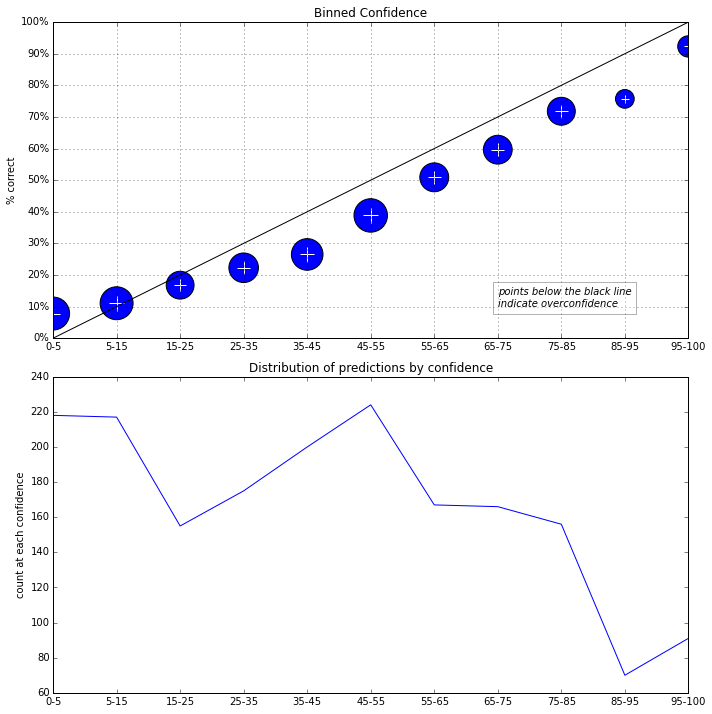

In [20]:
def makeCalibrationPlot(conf_profile):
    calibrationPlot = plt.figure(1,figsize=(10,10), dpi=100)
    topPlot = plt.subplot(211)
    topPlot.set_title("Binned Confidence")
    
    #calibrationPlot = Figure()#(figsize=None, dpi=None, facecolor=None, edgecolor=None, linewidth=0.0, frameon=None, subplotpars=None, tight_layout=None)
    #Plot the scatter, x is confidences
    plt.scatter( conf_profile["Confidence"].map(lambda x: x/10).tolist(),   #vector of y values (currently [0,1,2,3,4,5,6,7,8,9,10])
                 conf_profile.truePC,                                       #vector of x values
                 s=conf_profile.PredictionCountTotal*5)                     #vector of sizes
    #+ markers in the circles
    plt.scatter( conf_profile["Confidence"].map(lambda x: x/10).tolist(),   #vector of y values (currently [0,1,2,3,4,5,6,7,8,9,10])
                 conf_profile.truePC,                                       #vector of x values
                 s=conf_profile.PredictionCountTotal,                     #vector of sizes
                 marker='+',
                 color='w'
                 )
    #draw a diagonal line across the graph
    plt.plot([0, 10], [0, 1], 'k-', lw=1)
    plt.text( 7, 0.1, 'points below the black line \nindicate overconfidence', style='italic',
        bbox={'facecolor':'white', 'alpha':0.3, 'pad':10})
    
    #set the limits of the graph
    pylab.ylim([0,1])
    pylab.xlim([0,10])
    
    #add a background grid
    plt.grid()
    
    #make the ticks and labels
    plt.xticks([x    for x in range(11)], [x           for x in conf_profile["ConfidenceIntervals"].tolist()]) #locations, labels
    plt.yticks([x/10 for x in range(11)], [str(x)+ "%" for x in conf_profile["Confidence"].tolist()])
    
    plt.ylabel("% correct")
    
    #start the bottom plot
    bottomPlot = plt.subplot(212)
    bottomPlot.set_title("Distribution of predictions by confidence")
    plt.xticks([x    for x in range(11)], [x           for x in conf_profile["ConfidenceIntervals"].tolist()]) #locations, labels
    
    plt.plot( conf_profile["Confidence"].map(lambda x: x/10).tolist(),   #vector of y values (currently [0,1,2,3,4,5,6,7,8,9,10])
              conf_profile["PredictionCountTotal"])                      #vector of x values
    
    plt.ylabel("count at each confidence")
    
    plt.tight_layout()
    return plt
bins = getTrueAndFalsePredictions(500)
conf_profile = makeConfProfile(bins)
makeCalibrationPlot(conf_profile).show()

In [21]:
def pTOjRatio(this_user=500):
    p_count = queryAsTable("""select count(*) from  mysql.predictions p WHERE p.creator_id = '{}'""".format(this_user), maxrows=0)["count(*)"][0]
    j_count = queryAsTable("""select count(*) from  mysql.judgements j WHERE j.user_id = '{}'""".format(this_user), maxrows=0)["count(*)"][0]
    
    j_count = j_count if j_count!=0 else 0.00000001
    return p_count/ j_count
pTOjRatio()

1.7902912621359224

In [22]:
def timeBinThisUsersPredictions(this_user=500, windowSize=datetime.timedelta(weeks=16), windowStep=datetime.timedelta(weeks=2)):
    #print "this_user:  ",this_user
    #print "windowSize: ",windowSize
    #print "windowStep: ",windowStep
    
    q="""SELECT p.created_at from mysql.predictions as p 
         WHERE  p.creator_id = {0}
         ORDER BY p.created_at {1}
         LIMIT 1
         """

    firstPredictionForThisUser = queryAsTable(q.format(this_user,"ASC"), maxrows=0)["p.created_at"][0]
    #print "firstPredictionForThisUser: ",firstPredictionForThisUser

    lastPredictionForThisUser = queryAsTable(q.format(this_user,"DESC"), maxrows=0)["p.created_at"][0]
    #print "lastPredictionForThisUser:  ",lastPredictionForThisUser
    
    
    predictionWindowBins = []
    windowStart = firstPredictionForThisUser
    windowEnd   = windowStart + windowSize
    guard = 0
    while (windowEnd < lastPredictionForThisUser) and (guard<1000):
        guard += 1
        
        predictions = getTrueAndFalsePredictions(this_user, [windowStart, windowEnd])
        predictionWindowBins.append(predictions)
        #print "from: ",windowStart," to: ", windowEnd
        #print predictions
        windowStart = windowStart + windowStep
        windowEnd   = windowEnd   + windowStep
        
    return predictionWindowBins

timeBinThisUsersPredictions()

[{'falseDF':     Confidence  False_Prediction_count
  0            0                       9
  4           10                       4
  7           20                       5
  10          30                       5
  3           40                       1
  6           50                       0
  9           60                       1
  2           70                       4
  5           80                       1
  8           90                       0
  1          100                       0,
  'trueDF':     Confidence  True_Prediction_count
  0            0                      0
  4           10                      3
  7           20                      0
  10          30                      1
  3           40                      1
  6           50                      0
  9           60                      3
  2           70                      3
  5           80                      5
  8           90                      2
  1          100                      3},
 {'f

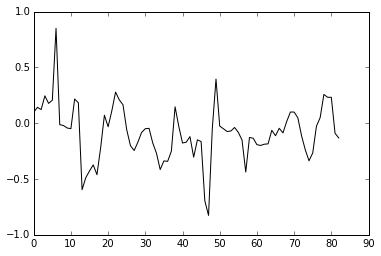

In [23]:
def quantifyUserTimeProfile(this_user = 500, windowSize=datetime.timedelta(weeks=12), windowStep=datetime.timedelta(weeks=2)):
    
    timeBins = timeBinThisUsersPredictions(this_user, windowSize, windowStep)
    
    #Process it a bit and make synthetic variables
    conf_profiles = [makeConfProfile(x) for x in timeBins]
    
    ssqe = [sum(x["signedSqError"].tolist()) for x in conf_profiles] 

    return ssqe

plot(quantifyUserTimeProfile(500,windowSize=datetime.timedelta(weeks=9), windowStep=datetime.timedelta(weeks=2)) , 'k')

In [24]:
def quantifyUser(this_user = 500):
    #sql query to get this user's stuff out of the DB
    bins = getTrueAndFalsePredictions(this_user)
    
    #Process it a bit and make synthetic variables
    conf_profile = makeConfProfile(bins)
      
    #sum of squared errors is an attempt to capture overall calibration
    sqe = sum(conf_profile["sqError"].tolist())
    #sum of signed squared errors is an attempt to capture the direction of calibration. If the result comes up negative then the predictor is generally overconfident.
    ssqe = sum(conf_profile["signedSqError"].tolist())

    rtn = {}    
    rtn["user"]                     = this_user    
    #rtn["calibrationPlot"]          = makeCalibrationPlot(conf_profile)
    rtn["summedSquaredError"]       = sqe
    rtn["signedSummedSquaredError"] = ssqe
    rtn["totalPredictions"]         = sum(conf_profile["PredictionCountTotal"].tolist())
    rtn["pTOjRatio"]                = pTOjRatio(this_user) 
    rtn = dict(rtn, **summarise_conf_profile(conf_profile))
    rtn = dict(rtn, **make_prediction_count_profile(this_user))
    rtn = dict(rtn, **quantifyUserTable(this_user))
    
    return rtn

quantifyUser()

{'0_falsePC': 0.92201834862385323,
 '0_signedSqErrorPC': 0.0,
 '0_sqErrorPC': 0.0,
 '0_truePC': 0.077981651376146793,
 '100_falsePC': 0.076923076923076927,
 '100_signedSqErrorPC': -0.0059171597633136015,
 '100_sqErrorPC': 0.0059171597633136015,
 '100_truePC': 0.92307692307692313,
 '10_falsePC': 0.88940092165898621,
 '10_signedSqErrorPC': 0.00011234046167894841,
 '10_sqErrorPC': 0.00011234046167894841,
 '10_truePC': 0.11059907834101383,
 '20_falsePC': 0.83225806451612905,
 '20_signedSqErrorPC': -0.0010405827263267429,
 '20_sqErrorPC': 0.0010405827263267429,
 '20_truePC': 0.16774193548387098,
 '30_falsePC': 0.77714285714285714,
 '30_signedSqErrorPC': -0.0059510204081632623,
 '30_sqErrorPC': 0.0059510204081632623,
 '30_truePC': 0.22285714285714286,
 '40_falsePC': 0.73499999999999999,
 '40_signedSqErrorPC': -0.018225000000000002,
 '40_sqErrorPC': 0.018225000000000002,
 '40_truePC': 0.26500000000000001,
 '50_falsePC': 0.6116071428571429,
 '50_signedSqErrorPC': -0.012456154336734693,
 '50_sq

In [25]:
class HighlightLines(plugins.PluginBase):
    """A plugin to highlight lines on hover"""

    JAVASCRIPT = """
    mpld3.register_plugin("linehighlight", LineHighlightPlugin);
    LineHighlightPlugin.prototype = Object.create(mpld3.Plugin.prototype);
    LineHighlightPlugin.prototype.constructor = LineHighlightPlugin;
    LineHighlightPlugin.prototype.requiredProps = ["line_ids"];
    LineHighlightPlugin.prototype.defaultProps = {alpha_bg:0.3, alpha_fg:1.0}
    function LineHighlightPlugin(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    LineHighlightPlugin.prototype.draw = function(){
      for(var i=0; i<this.props.line_ids.length; i++){
         var obj = mpld3.get_element(this.props.line_ids[i], this.fig),
             alpha_fg = this.props.alpha_fg;
             alpha_bg = this.props.alpha_bg;
         obj.elements()
             .on("mouseover", function(d, i){
                            d3.select(this).transition().duration(50)
                              .style("stroke-opacity", alpha_fg); })
             .on("mouseout", function(d, i){
                            d3.select(this).transition().duration(200)
                              .style("stroke-opacity", alpha_bg); });
      }
    };
    """

    def __init__(self, lines):
        self.lines = lines
        self.dict_ = {"type": "linehighlight",
                      "line_ids": [utils.get_id(line) for line in lines],
                      "alpha_bg": lines[0].get_alpha(),
                      "alpha_fg": 1.0}

In [26]:
def safeVal(x):
    if abs(x)== float('Inf'):
        return 0
    if math.isnan(x):
        return 0
    return x

print safeVal(float('Inf'))
print safeVal(-float('Inf'))
print safeVal(float('NaN'))
print safeVal(5)

0
0
0
5


# Exploration #

## tables ##
This section goes through the tables to get an idea of what's going on inside them

In [27]:
queryAsTable("""
SELECT table_name, 
       table_rows 
FROM   information_schema.tables 
WHERE  table_type = 'BASE TABLE' 
       AND table_schema = 'mysql' 
ORDER  BY table_rows DESC
""", maxrows=10)


,tables.table_name,tables.table_rows
0,responses,45446
1,users,22235
2,predictions,21913
3,judgements,10798
4,help_relation,1215
5,help_keyword,608
6,help_topic,583
7,help_category,40
8,user,5
9,plugin,4


So it looks like there's not really any point thinking about any tables other than responses, predictions, users and judgements.

The help tables seem to be mysql help, not predictionbook help!

### responses ###

In [28]:
queryAsTable("""select * from  mysql.responses""", maxrows=10)

,responses.confidence,responses.created_at,responses.id,responses.prediction_id,responses.updated_at,responses.user_id
0,80,2008-06-20 03:46:16,1,1,2008-08-01 09:18:02,1
1,60,2008-06-20 04:37:13,2,2,2008-08-01 09:18:02,2
2,80,2008-06-20 04:38:35,3,3,2008-08-01 09:18:02,3
3,80,2008-06-20 04:40:06,4,4,2008-08-01 09:18:02,3
4,70,2008-06-20 05:08:31,5,5,2008-08-01 09:18:02,4
5,70,2008-06-20 05:24:24,6,6,2008-08-01 09:18:02,2
6,90,2008-06-20 06:46:23,7,7,2008-08-01 09:18:02,5
7,80,2008-06-20 11:43:07,8,8,2008-08-01 09:18:02,6
8,95,2008-06-20 11:47:54,9,9,2008-08-01 09:18:02,6
9,78,2008-06-20 12:12:28,10,10,2008-08-01 09:18:02,7


### predictions ###

In [29]:
queryAsTable("""select * from  mysql.predictions""", maxrows=10)

,predictions.created_at,predictions.creator_id,predictions.deadline,predictions.id,predictions.private,predictions.updated_at,predictions.uuid,predictions.version,predictions.withdrawn
0,2008-06-20 03:46:16,1,2008-06-20 12:00:00,1,0,2008-08-14 02:28:40,d52eeaf6-cb20-456f-a375-bec2d1acc44d,1,0
1,2008-06-20 04:37:13,2,2008-06-23 12:00:00,2,0,2008-08-01 09:18:01,86530ca2-fbd5-47a8-b2d8-12110e05c3b4,1,0
2,2008-06-20 04:38:35,3,2008-06-30 12:00:00,3,0,2008-08-01 09:18:01,d5adb0ee-ecf2-48ce-88ce-7b40b5b2179f,1,0
3,2008-06-20 04:40:06,3,2008-06-19 12:00:00,4,0,2008-08-01 09:18:01,100f4ff6-4ee7-44e8-aa2d-5394dcaead7e,1,0
4,2008-06-20 05:08:31,4,2008-06-20 06:08:31,5,0,2008-08-01 09:18:01,c0314cd4-070a-4d4b-ae3c-ec03ddbdc621,1,0
5,2008-06-20 05:24:24,2,2008-06-26 12:00:00,6,0,2008-08-01 09:18:01,5c73114a-e22d-4a5a-9026-03f45acc0f19,1,0
6,2008-06-20 06:46:23,5,2008-12-30 12:00:00,7,0,2008-08-01 09:18:01,54df1626-bf7a-4ae9-b162-826d2a67fec1,1,0
7,2008-06-20 11:43:07,6,2008-08-01 12:00:00,8,0,2008-08-01 09:18:01,d5fbc343-9de5-41a2-ba89-b599bf60ae81,1,0
8,2008-06-20 11:47:54,6,2013-01-06 12:00:00,9,1,2013-01-26 01:15:36,ffa789d4-c40e-489e-af69-7000ce34cbf0,2,0
9,2008-06-20 12:12:28,7,2013-06-20 22:00:00,10,1,2013-11-01 18:38:07,19128b35-38ac-4748-9a44-42cbda3309fb,2,0


### Users ###

In [30]:
queryAsTable("""select * from  mysql.users""", maxrows=10)

,users.created_at,users.id,users.private_default,users.timezone,users.updated_at
0,2008-08-01 09:18:00,1,0,None,2013-08-28 06:34:18
1,2008-08-01 09:18:00,2,0,None,2012-10-12 01:52:14
2,2008-08-01 09:18:00,3,0,None,2008-08-01 09:18:00
3,2008-08-01 09:18:00,4,0,London,2013-01-11 01:47:45
4,2008-08-01 09:18:00,5,0,None,2008-08-01 09:18:00
5,2008-08-01 09:18:00,6,0,Melbourne,2008-09-08 05:58:02
6,2008-08-01 09:18:00,7,0,None,2013-06-06 02:00:49
7,2008-08-01 09:18:00,8,0,Melbourne,2009-05-13 06:49:42
8,2008-08-01 09:18:00,9,0,Melbourne,2013-03-15 04:21:33
9,2008-08-01 09:18:00,10,0,None,2008-08-01 09:18:00


### Judgements ###

In [31]:
queryAsTable("""select * from  mysql.judgements""", maxrows=10)

,judgements.created_at,judgements.id,judgements.outcome,judgements.prediction_id,judgements.updated_at,judgements.user_id
0,2008-08-14 02:28:40,1,1,1,2008-08-14 02:28:40,None
1,2008-08-01 09:18:01,2,0,2,2008-08-01 09:18:01,None
2,2008-08-01 09:18:01,3,0,3,2008-08-01 09:18:01,None
3,2008-08-01 09:18:01,4,0,4,2008-08-01 09:18:01,None
4,2008-08-01 09:18:01,5,1,5,2008-08-01 09:18:01,None
5,2008-08-01 09:18:01,6,0,6,2008-08-01 09:18:01,None
6,2008-08-01 09:18:01,8,0,8,2008-08-01 09:18:01,None
7,2008-08-01 09:18:01,12,0,12,2008-08-01 09:18:01,None
8,2008-08-01 09:18:01,13,0,15,2008-08-01 09:18:01,None
9,2008-08-01 09:18:01,14,1,16,2008-08-01 09:18:01,None


So the general structure of this seems to be that a **user** makes a **prediction**. The prediction is just the *what* part of the **prediction**, i.e. the text, e.g. '*Newtown jets will win the superbowl*'. At the same time the user makes a **response** to that **prediction**. The **response** is the part where they assign a *confidence* in it. 

Each **prediction** can have many **response**s.

A **prediction** can later be judged, [TODO: check if each prediction only hasone or can hasmany judgements? The site records many judgements, so my guess is that it post processes them at render time; meaning that I'll need to search for the most recent one.]

------------------
Before we get into trying to merge these, lets see how many users there are, and how many predictions they've made:

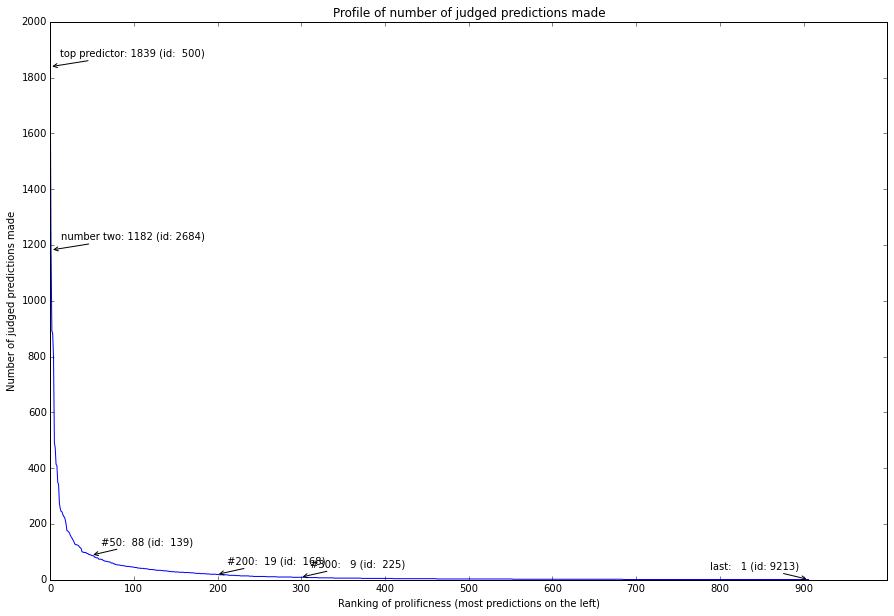

In [32]:
#we know that user 500 is the most prolific, so we can use them to set some boundaries on the graph
u = quantifyUser(500)

#This query counts the number of judged predictions each user has made
countPredictions_query = """
SELECT r.user_id, 
       Count(r.user_id) 
FROM   mysql.responses r 
       LEFT OUTER JOIN mysql.judgements j 
                    ON r.prediction_id = j.prediction_id 
WHERE  j.outcome {0} NULL 
       AND r.confidence {1} NULL 
GROUP  BY r.user_id 
ORDER  BY Count(r.user_id) DESC  
"""
count_judged_prediction_df = queryAsTable(countPredictions_query.format('IS NOT','IS NOT'), maxrows=0)
response_counts = count_judged_prediction_df.drop("r.user_id",1)

fig, ax = plt.subplots(figsize=(15,10), dpi=100)
ax.plot(response_counts)
plt.yticks(range(0,u["totalPredictions"]+200,200))
plt.xticks(range(0,1000,100))
arrow = dict(arrowstyle='->', shrinkA=0)
ax.annotate("top predictor: {:>4} (id:{:>5})".format( count_judged_prediction_df["Count(r.user_id)"][0],   count_judged_prediction_df.iloc[0]['r.user_id']  ), xy=(0,   count_judged_prediction_df["Count(r.user_id)"][0]),   xytext=(10, 10), ha='left', textcoords='offset points', arrowprops=arrow)
ax.annotate("number two: {:>4} (id:{:>5})".format(    count_judged_prediction_df["Count(r.user_id)"][1],   count_judged_prediction_df.iloc[1]['r.user_id']  ), xy=(1,   count_judged_prediction_df["Count(r.user_id)"][1]),   xytext=(10, 10), ha='left', textcoords='offset points', arrowprops=arrow)
ax.annotate("#50:{:>4} (id:{:>5})".format(            count_judged_prediction_df["Count(r.user_id)"][49],  count_judged_prediction_df.iloc[49]['r.user_id'] ), xy=(49,  count_judged_prediction_df["Count(r.user_id)"][49]),  xytext=(10, 10), ha='left', textcoords='offset points', arrowprops=arrow)
ax.annotate("#200:{:>4} (id:{:>5})".format(           count_judged_prediction_df["Count(r.user_id)"][199], count_judged_prediction_df.iloc[199]['r.user_id']), xy=(199, count_judged_prediction_df["Count(r.user_id)"][199]), xytext=(10, 10), ha='left', textcoords='offset points', arrowprops=arrow)
ax.annotate("#300:{:>4} (id:{:>5})".format(           count_judged_prediction_df["Count(r.user_id)"][299], count_judged_prediction_df.iloc[299]['r.user_id']), xy=(299, count_judged_prediction_df["Count(r.user_id)"][299]), xytext=(10, 10), ha='left', textcoords='offset points', arrowprops=arrow)
last=len(count_judged_prediction_df['r.user_id'])-1
ax.annotate("last:{:>4} (id:{:>5})".format(           count_judged_prediction_df["Count(r.user_id)"][last], count_judged_prediction_df.iloc[last]['r.user_id']), xy=(last, count_judged_prediction_df["Count(r.user_id)"][last]), xytext=(-10, 10), ha='right', textcoords='offset points', arrowprops=arrow)

plt.xlabel('Ranking of prolificness (most predictions on the left)')
plt.ylabel('Number of judged predictions made')
plt.title('Profile of number of judged predictions made')

plt.show()

This graph shows how fast the number of people who have made predictions drops off.

Below is where we pluck people from that complete dataset to work with. The value of people who have made less than 20 predictions is going to be pretty low, so lets cut it off at the top 200 users.

In [33]:
set_size = 200

peopleToLookAt = []
for i in range(set_size):
    peopleToLookAt.append( count_judged_prediction_df.iloc[i]['r.user_id'])
print peopleToLookAt

[500, 2684, 535, 642, 4758, 2678, 579, 292, 9112, 2649, 496, 560, 140, 247, 591, 557, 9, 16489, 18514, 2504, 85, 205, 1, 2632, 2499, 94, 559, 16970, 15788, 1434, 164, 667, 946, 4611, 12401, 3954, 4600, 2939, 136, 7148, 905, 131, 3876, 16304, 554, 16898, 135, 527, 98, 139, 641, 137, 17348, 143, 6036, 1285, 1293, 149, 1074, 2982, 33, 21058, 2038, 2584, 6820, 903, 16658, 2, 93, 586, 88, 7259, 5319, 6826, 16175, 17549, 15515, 19238, 4707, 3553, 1521, 92, 188, 15135, 2576, 668, 4797, 4, 6, 216, 4713, 11118, 183, 197, 1333, 210, 90, 6608, 62, 18806, 369, 42, 147, 12343, 20547, 12367, 1083, 17955, 585, 16545, 19596, 74, 1177, 173, 1468, 2663, 200, 598, 181, 19, 6729, 142, 358, 6736, 7, 4752, 170, 119, 582, 1590, 227, 2546, 190, 590, 101, 9254, 16302, 154, 3965, 184, 542, 599, 174, 6977, 491, 4396, 18978, 163, 18651, 2178, 14302, 215, 9214, 18291, 982, 9666, 3879, 175, 7352, 478, 2761, 630, 595, 4598, 530, 5286, 19500, 607, 573, 13309, 2321, 290, 15279, 2124, 603, 6776, 644, 5219, 658, 9852, 6

The `quantifyUser` function chews through the people in the set produced above, and tries to make a row for the Grand Dataset Of Everything out of them. Some fail for no good reason (that I've found), so they get ignored for the moment.

In [34]:
#u
#check the types
#for k in u:
#    print type(u[k]),k,u[k]

In [35]:
peopleToLookAt = [int(x) for x in peopleToLookAt]

In [36]:
quantified_users=[]
counter=0
error_people = []
for id in peopleToLookAt:
    try:
        person = quantifyUser(int(id))
        quantified_users.append(person)        
    except:        
        error_people.append(int(id))
print  error_people,"caused errors"

#This causes a load of errors
#seems to be documented here: https://github.com/pydata/pandas/issues/5824
#caused by a call to describe

[946, 1285, 2584, 188, 216, 6608, 369, 200, 181, 1590, 227, 184, 2178, 4598, 2124, 658, 16430, 10399, 15016, 6688, 217, 168] caused errors


In [37]:
len(quantified_users) #this is how many people made it through unscathed

178

At this point we have a massive wide dataset, with lots of rows. They get less useful as we go down, but it might be more useful than just having 45 fairly OK ones.



In [38]:
qudf = pd.DataFrame(quantified_users) #convert the list of dictionaries into a pandas dataframe
# zip(qudf.user,qudf.totalPredictions)

In [ ]:
logqudf = pd.DataFrame()

for colName in qudf.columns.tolist():
        logqudf[colName] = qudf[colName].apply(log)
        logqudf[colName] = logqudf[colName].apply(safeVal)

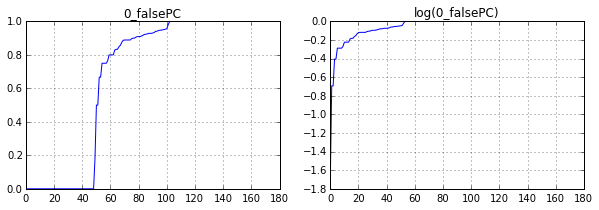

In [ ]:
for colName in logqudf.columns.tolist():
    
    fig = plt.figure(figsize=(10,3), dpi=100)
    
    subplot(1,2,1); 
    plot(qudf[colName].order())
    grid(True)
    plt.title(colName)
        
    subplot(1,2,2); 
    plot(logqudf[colName].order())
    grid(True)
    plt.title("log({})".format(colName))

    show()
    print colName

In [ ]:
logqudf.to_csv("./userslog.csv")

In [ ]:
fig = plt.figure(figsize=(15,7.5), dpi=100)
plot(qudf[ 'signedSummedSquaredError'])
grid(True)
xticks(range(0,len(quantified_users)+10,10))
plt.xlabel('Ranking of prolificness (most predictions on the left)')
plt.ylabel(u'signed ∑SE')
plt.title(u'Signed ∑ of Squared error for each user')
show()
#it would be worth ploting these two with number of predictions on the x axis. it would probably bunch them up way too much, but maybe with a log transform it would be useful

There seems to be a bit of a funnel away from the top predictors. The most enthusiastic predictors are the best calibrated, although I don't know how to disentangle this from just the law of large numbers (or if this has any effect at all!)

In general it seems that the top 30 or so predictors are below the 0 line, whereas in general the rest of the pack is above it. I need to check this, but I think that below is generally underconfident, and above, generally overconfident.

In [ ]:
fig = plt.figure(figsize=(15,7.5), dpi=100)
plot(qudf[ 'summedSquaredError'])
grid(True)
xticks(range(0,len(quantified_users)+10,10))
plt.xlabel('Ranking of prolificness (most predictions on the left)')
plt.ylabel(u'∑SE')
plt.title(u'∑ of Squared error for each user')
show()

The range of the SSE seems to be pretty constant through the middle section of the graph. I think it goes down again when we get to about 200 because people at that point have made so few prediction that there's not much to go on by then. (Remember predictor #100 had only made 46 predictions!)

##Do people get better calibrated over time?

A pretty obvious question is do people get 'better' (i.e. seem to have better calibration) over time? in fact, there's an issue for this on the repo: [Find out if PB makes people better calibrated over time](https://github.com/tricycle/predictionbook/issues/32) It seems like using prediction book should lead to improvements, lets see:

In [ ]:
fig, ax = plt.subplots(figsize=(15,10), dpi=100)
ax.plot(quantifyUserTimeProfile(500,windowSize=datetime.timedelta(weeks=24),  windowStep=datetime.timedelta(weeks=2)) , 'r--')
ax.plot(quantifyUserTimeProfile(500,windowSize=datetime.timedelta(weeks=18),  windowStep=datetime.timedelta(weeks=2)) , 'r')
ax.plot(quantifyUserTimeProfile(500,windowSize=datetime.timedelta(weeks=12),  windowStep=datetime.timedelta(weeks=2)) , 'g')
ax.plot(quantifyUserTimeProfile(500,windowSize=datetime.timedelta(weeks=9),   windowStep=datetime.timedelta(weeks=2)) , 'k')
ax.plot(quantifyUserTimeProfile(500,windowSize=datetime.timedelta(weeks=6),   windowStep=datetime.timedelta(weeks=2)) , 'b')
ax.plot(quantifyUserTimeProfile(500,windowSize=datetime.timedelta(weeks=3),   windowStep=datetime.timedelta(weeks=2)) , 'y')
ax.plot(quantifyUserTimeProfile(500,windowSize=datetime.timedelta(weeks=2),   windowStep=datetime.timedelta(weeks=2)) , 'y--')
ax.plot([0, 90], [0, 0], 'k--')
# yticks(range(0,u["totalPredictions"]+200,200))
# xticks(range(0,1000,100))
# arrow = dict(arrowstyle='->', shrinkA=0)
# ax.annotate("top predictor: {:>4} (id:{:>5})".format( count_judged_prediction_df["Count(r.user_id)"][0],   count_judged_prediction_df.iloc[0]['r.user_id']  ), xy=(0,   count_judged_prediction_df["Count(r.user_id)"][0]),   xytext=(10, 10), ha='left', textcoords='offset points', arrowprops=arrow)

plt.xlabel('rolling calibration score')
plt.ylabel('summed square error')
plt.title('time steps since start')

plt.show()

The way I'm showing this is by going a <acronym title="signed summed squared error">SSSE </acronym> for a window of time, and then moving the window. The bigger the window the more damping there is going to be. The graph above shows the results for user 500 over their whole PB lifespan moving 2 weeks at a time. The difference between the lines is the window size. I think there is some kind of comparison error here as the red lines don't seem to be a more damped version of the yellow ones, but as long as I keep the window size the same for all the users it ought to be comparable.

In [ ]:
usefulUsers = [500,2684,535,642,4758,2678,579,292,9112,2649,496,560,140,247,591,557,9,16489,18514,2504,85,205,1,2632,2499,94,559,16970,15788,1434,667,164,4611,12401,3954,4600,2939]

fig, ax = plt.subplots(figsize=(10,10), dpi=100)

lines = []
for user in usefulUsers:
    values = quantifyUserTimeProfile(user,windowSize=datetime.timedelta(weeks=8), windowStep=datetime.timedelta(weeks=1))
    lines.append( ax.plot(values, label="user "+str(user),lw=4, alpha=0.1 )[0] )


ax.plot([0, 140], [0, 0], 'k--')

# ax.legend()

# yticks(range(0,u["totalPredictions"]+200,200))
# xticks(range(0,1000,100))
# arrow = dict(arrowstyle='->', shrinkA=0)
# ax.annotate("top predictor: {:>4} (id:{:>5})".format( count_judged_prediction_df["Count(r.user_id)"][0],   count_judged_prediction_df.iloc[0]['r.user_id']  ), xy=(0,   count_judged_prediction_df["Count(r.user_id)"][0]),   xytext=(10, 10), ha='left', textcoords='offset points', arrowprops=arrow)

plt.xlabel('time steps since start')
plt.ylabel('summed square error')
plt.title('rolling calibration score')

plugins.connect(fig, HighlightLines(lines))

mpld3.display()


Rather disapointingly, it seems that the questions is unanswered. There *seems* to be some kind of trend towards the 0 line as we travel right, but not in enough people to let me believe that it is more than me just seeing what I want to see.

I don't think that this is a conclusive death knell for the usefullness of PB, I think that it is far mroe likely that I'm missing something fundamental.

-----

#Clusters

To perform a k means clustering on this dataset it needs to be cleaned up a little bit. There are some missing values where there was no count (e.g. no predictions at 100%, or none with a >50 year outlook). The data also needs to be scaled so that big numbers like the prediction count don't swamp small ones like the prediction percentages.

In [ ]:
qudfNoNA = logqudf.fillna(0) #put a 0 in all the empty spots as they come about through there being nothing to count
qudfNoNA.to_csv("./users.csv")
#zip(range(len(qudfNoNA.columns)),qudfNoNA.columns)

In [ ]:
#print qudfNoNA.columns
#print qudfNoNA["pTOjRatio"]
#print qudfNoNA["0_falsePC"]

In [ ]:
qudf_scaled = preprocessing.scale(qudfNoNA)
numpy.savetxt("./qudf_scaled.csv", qudf_scaled, delimiter=",") #qudf_scaled.to_csv("./scaled_users.csv") #error: 'numpy.ndarray' object has no attribute 'to_csv'

In [ ]:
#scaled_DF = pd.DataFrame(qudf_scaled, columns=qudfNoNA.columns).iloc[0]
#for col, name in zip(scaled_DF, qudfNoNA.columns):
#    print col,name

Computing K-Means with K = n (n clusters)

Trying it with `clusterRange` clusters, i.e. with 1 cluster, then 2... and then graphing the within cluster errors at the end to see where the value of adding more clusters drops off.

In [ ]:
clusterRange = range(1,15)
msse4k = []
for k in clusterRange:
    centroids,junk = kmeans(qudf_scaled,k)
    idx,dist = vq(qudf_scaled,centroids)
    #idx #vector assigning people to a given cluster
    #dist #The distortion (distance) between the observation and its nearest code.

    clusterStat = [[] for x in range(k)] # make a list of empty lists e.g. [[], [], [], [], [], [], [], []] that is the same length as the number of clusters
    pairs = zip(dist,idx)
    #print "d",len(dist)
    #print "i",len(idx)
    
    for distance,index in pairs:
        clusterStat[index].append(distance**2)

    sums    = [sum(x) for x in clusterStat]
    average = np.mean(sums)
    msse4k.append(average)

In [ ]:
plt.figure(figsize=(14,10))
plt.plot(clusterRange,msse4k)
plt.xticks(clusterRange)
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')
plt.show()

It looks like most of the usefullness has gone out of the clustering by the time we get to 5 clusters.

Oddly the elbow isn't as pronounced as it is in the examples I've seen. I wonder if the high dimenntionality of the dataset is what is causing the rounded elbow?

So doing a clustering with 5 clusters we get a vector of cluster indexes. They aren't scaled so if we glue them onto the end of the scaled data it'll throw it out of whack, so I'm going to put them onto the end of the quantified user data frame (`qudf`) and then rescale it.

In [ ]:
k=5
centroids,junk = kmeans(qudf_scaled,k)
idx,dist = vq(qudf_scaled,centroids)

idx

In [ ]:
qudf_wID = qudf
qudf_wID["clusterID"]=idx

qudf.to_csv("./users.csv")

qudf_scaled_wID = preprocessing.scale(qudf_wID)

![predictors in this clustering, coloured by cluster, ordered by number of predictions](https://lh5.googleusercontent.com/-UOLGeUuCK7Q/Uv_uQFG63HI/AAAAAAAAP3Q/PHbE34r-GPM/w702-h21-no/all+factors+-+sorted+by+prediction+count.png) &Larr; predictors in this clustering, coloured by cluster, ordered by number of predictions.

This image, grabbed after doing some manual data fiddling in a spreadsheet seems to say that there is *some* correlation between the number of predictions a person has made, and their likelyhood of being in cluster 2 (seemingly for frequent predictors) or cluster 3 (seemingly for infrequent predictors). I think that it would be worth rerunning the clustering without the `totalPredictions` column to see if this tendency still exists.

In [ ]:
%config InlineBackend.figure_format = 'png' #svg for these is punishingly slow

In [ ]:
colors = [(cm.jet(i)) for i in xrange(1,256)]
new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=256)

fig = plt.figure(figsize=(35,20),  dpi=100)
pcolor(qudf_scaled_wID, cmap=new_map, vmin=-1.1, vmax=1.1)
colorbar()
data_width = qudf_scaled_wID.shape[1]-1
xticks(range(0,data_width,1))
title('Map of person data (rows) sorted by Number of predictions (col 78)')
show()

<pre>
  | 0 : '0_falsePC'           | 20 : '40_falsePC'         | 40 : '90_falsePC'         | 60 : 'pcp_month'                |
  | 1 : '0_signedSqErrorPC'   | 21 : '40_signedSqErrorPC' | 41 : '90_signedSqErrorPC' | 61 : 'pcp_month_pc'             |
  | 2 : '0_sqErrorPC'         | 22 : '40_sqErrorPC'       | 42 : '90_sqErrorPC'       | 62 : 'pcp_overFiftyYear'        |
  | 3 : '0_truePC'            | 23 : '40_truePC'          | 43 : '90_truePC'          | 63 : 'pcp_overFiftyYear_pc'     |
  | 4 : '100_falsePC'         | 24 : '50_falsePC'         | 44 : 'creationDate'       | 64 : 'pcp_postHoc'              |
  | 5 : '100_signedSqErrorPC' | 25 : '50_signedSqErrorPC' | 45 : 'hasSetTZ'           | 65 : 'pcp_postHoc_pc'           |
  | 6 : '100_sqErrorPC'       | 26 : '50_sqErrorPC'       | 46 : 'pTOjRatio'          | 66 : 'pcp_simultanious'         |
  | 7 : '100_truePC'          | 27 : '50_truePC'          | 47 : 'pcp_25%'            | 67 : 'pcp_simultanious_pc'      |
  | 8 : '10_falsePC'          | 28 : '60_falsePC'         | 48 : 'pcp_50%'            | 68 : 'pcp_std'                  |
  | 9 : '10_signedSqErrorPC'  | 29 : '60_signedSqErrorPC' | 49 : 'pcp_75%'            | 69 : 'pcp_tenYear'              |
  | 10 : '10_sqErrorPC'       | 30 : '60_sqErrorPC'       | 50 : 'pcp_FiftyYear'      | 70 : 'pcp_tenYear_pc'           |
  | 11 : '10_truePC'          | 31 : '60_truePC'          | 51 : 'pcp_FiftyYear_pc'   | 71 : 'pcp_week'                 |
  | 12 : '20_falsePC'         | 32 : '70_falsePC'         | 52 : 'pcp_count'          | 72 : 'pcp_week_pc'              |
  | 13 : '20_signedSqErrorPC' | 33 : '70_signedSqErrorPC' | 53 : 'pcp_day'            | 73 : 'pcp_year'                 |
  | 14 : '20_sqErrorPC'       | 34 : '70_sqErrorPC'       | 54 : 'pcp_day_pc'         | 74 : 'pcp_year_pc'              |
  | 15 : '20_truePC'          | 35 : '70_truePC'          | 55 : 'pcp_fiveYear'       | 75 : 'privateDefault'           |
  | 16 : '30_falsePC'         | 36 : '80_falsePC'         | 56 : 'pcp_fiveYear_pc'    | 76 : 'signedSummedSquaredError' |
  | 17 : '30_signedSqErrorPC' | 37 : '80_signedSqErrorPC' | 57 : 'pcp_max'            | 77 : 'summedSquaredError'       |
  | 18 : '30_sqErrorPC'       | 38 : '80_sqErrorPC'       | 58 : 'pcp_mean'           | 78 : 'totalPredictions'         |
  | 19 : '30_truePC'          | 39 : '80_truePC'          | 59 : 'pcp_min'            | 79 : 'user'                     |
  |                           |                           |                           | 80 : 'clusterID'                |
</pre>


<div style="float:right; width:400px; margin:0 5em;">The colour map is drawn in the opposite order to the array, with the first element at the bottom.
`zip(range(0,len(qudf.columns)),qudf.columns)` produces
</div>
This colour map is sorted by virtue of the order that the data was created in; most prolific predictors to least. It seems to get more chaotic towards the bottom, but this might just because the data quality increases, wheras near the top there are a lot of missing values and zeroes.

Column 64 is prediction count, it has a smooth gradient from a few reds, then quickly dropping off to a slow change from green to blue. This is the same elbow seen above in the predictions count graph.

Column 66 is cluster ID, it is almost all red up to person #40 which is where the hockey stick's head starts to turn into it's shaft. There isn't that much grouping of colours in the rest of that bar, so it seems that predicton count is the most powerful factor in this clustering. Realistically this is probably completely legitimate as prolific predictors also seem to be well calibrated, but lets see what happens when we cluster without the prediction count column.

Here it is again sorted by cluster

In [ ]:
data_width = qudf_scaled_wID.shape[1]-1
data_width

`data_width` tells me how wide the table is so that I know to pull the last column off, regardless of how wide it is.

In [ ]:
sortCol=data_width
qudf_scaled_wID_sorted = qudf_scaled_wID[qudf_scaled_wID[:,sortCol].argsort()]


colors = [(cm.jet(i)) for i in xrange(1,256)]
new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=256)

fig = plt.figure(figsize=(35,20),  dpi=100)
pcolor(qudf_scaled_wID_sorted, cmap=new_map, vmin=-1.1, vmax=1.1)
colorbar()
data_width = qudf_scaled_wID_sorted.shape[1]
xticks(range(0,data_width,1))
title('Map of person data (rows) sorted by cluster ID (col {})'.format(sortCol-1))
show()

In [ ]:
sortCol=75
qudf_scaled_wID_sorted = qudf_scaled_wID[qudf_scaled_wID[:,sortCol].argsort()]


colors = [(cm.jet(i)) for i in xrange(1,256)]
new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=256)

fig = plt.figure(figsize=(35,20), dpi=100)
pcolor(qudf_scaled_wID_sorted, cmap=new_map, vmin=-1.1, vmax=1.1)
colorbar()
data_width = qudf_scaled_wID_sorted.shape[1]
xticks(range(0,data_width,1))
title('Map of person data (rows) sorted by cluster ID (col {})'.format(sortCol-1))
show()

The last column is the cluster ID, and we can see from the blocking that it has sorted it properly. Looking for characteristics in the rest of the table there seems to be a band through the bottom of cluster 0 (the red one). This band seems to correspond to a block of high predictors in column 64. All of these people are in the same cluster.

In [ ]:
def cmap_of_clustering(data, k=5, titleString="", sort_column=None):
    #scale the data
    scaled_data = preprocessing.scale(data)
    
    #run the clustering
    centroids,junk = kmeans(scaled_data,k)
    idx,dist = vq(scaled_data,centroids)
    
    #append the cluster IDs to the data
    data["clusterID"] = idx
    #scale the data again not that it has cluster IDs (this feels ineficient)
    scaled_data = preprocessing.scale(data)
    
    #sort the data by cluster ID
    data_width = scaled_data.shape[1]-1
    sort_column = (data_width) if sort_column == None else sort_column
    sorted_scaled_data = scaled_data[scaled_data[:,sort_column].argsort()]
    
    #make the plot
    colors = [(cm.jet(i)) for i in xrange(1,256)]
    new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=256)
    
    fig = plt.figure(figsize=(15,10), dpi=100)
    pcolor(sorted_scaled_data, cmap=new_map, vmin=-1.1, vmax=1.1)
    colorbar()
    xticks(range(0,data_width,1))
    title(titleString)
    show()

In [ ]:
cmap_of_clustering(logqudf, k=5, titleString='Map of person data (rows) sorted by cluster ID - Log transform')#, sort_column=75))
    

In [ ]:
cmap_of_clustering(qudf, k=5, titleString='Map of person data (rows) sorted by cluster ID - again')#, sort_column=75)

Immediatly above is exactly the same data as above, so *should* come out roughly the same.

In [ ]:
dataWithNoTotalCounts = qudf.drop(["totalPredictions"],1)
cmap_of_clustering(dataWithNoTotalCounts, k=5, titleString='Map of person data (rows) sorted by cluster ID; prediction count removed')

Without the total counts there still seems to be a strong band. Lets see if it's the count columns as these would order people by their prolificness. I've also take out user ID as this isn't related to anything at all, but if we can get away with it I'd like to leave it in so that we can see who's who

In [ ]:
dataWithNoCountsAtAll = qudf.drop([ "user",
                                    "totalPredictions" , "pcp_min","pcp_month","pcp_overFiftyYear","pcp_postHoc",
                                    "pcp_simultanious" , "pcp_tenYear",        "pcp_week","pcp_year","totalPredictions",
                                    "clusterID"        , "pcp_25%","pcp_50%",  "pcp_75%","pcp_FiftyYear","pcp_count",
                                    "pcp_day"          , "pcp_fiveYear",       "pcp_max"],1)

cmap_of_clustering(dataWithNoCountsAtAll, k=5, titleString='Map of person data (rows) sorted by cluster ID; all count variables removed')

I can see two major blobs here if I screw up my eyes, one is reflected in a cluster (the largest cluster), but the other is probably just an accident. 

The big, dark red blocks are proving to be a strong enough feature that they are makign clusters that only include them. They only really start to show up in this view though. The blocks are all associated with error values, but as they dont seem to have any other blocks that line up with them they are probably just anolylous groups of people who are hugely overconfident in a certain area of the calibration spectrum.

<pre>
  | 0 | 0_falsePC           | 10 | 10_sqErrorPC       | 20 | 40_falsePC         | 30 | 60_sqErrorPC       | 40 | 90_falsePC           | 50 | pcp_postHoc_pc           |
  | 1 | 0_signedSqErrorPC   | 11 | 10_truePC          | 21 | 40_signedSqErrorPC | 31 | 60_truePC          | 41 | 90_signedSqErrorPC   | 51 | pcp_simultanious_pc      |
  | 2 | 0_sqErrorPC         | 12 | 20_falsePC         | 22 | 40_sqErrorPC       | 32 | 70_falsePC         | 42 | 90_sqErrorPC         | 52 | pcp_std                  |
  | 3 | 0_truePC            | 13 | 20_signedSqErrorPC | 23 | 40_truePC          | 33 | 70_signedSqErrorPC | 43 | 90_truePC            | 53 | pcp_tenYear_pc           |
  | 4 | 100_falsePC         | 14 | 20_sqErrorPC       | 24 | 50_falsePC         | 34 | 70_sqErrorPC       | 44 | pcp_FiftyYear_pc     | 54 | pcp_week_pc              |
  | 5 | 100_signedSqErrorPC | 15 | 20_truePC          | 25 | 50_signedSqErrorPC | 35 | 70_truePC          | 45 | pcp_day_pc           | 55 | pcp_year_pc              |
  | 6 | 100_sqErrorPC       | 16 | 30_falsePC         | 26 | 50_sqErrorPC       | 36 | 80_falsePC         | 46 | pcp_fiveYear_pc      | 56 | signedSummedSquaredError |
  | 7 | 100_truePC          | 17 | 30_signedSqErrorPC | 27 | 50_truePC          | 37 | 80_signedSqErrorPC | 47 | pcp_mean             | 57 | summedSquaredError       |
  | 8 | 10_falsePC          | 18 | 30_sqErrorPC       | 28 | 60_falsePC         | 38 | 80_sqErrorPC       | 48 | pcp_month_pc         | 58 | clusterID                |
  | 9 | 10_signedSqErrorPC  | 19 | 30_truePC          | 29 | 60_signedSqErrorPC | 39 | 80_truePC          | 49 | pcp_overFiftyYear_pc |    |                                          | 
</pre>

*todo next:*

 * look at the vectors in each cluster, see if there is any obvious commonality between them
 * start taking columns out of the clustering to see if it makes any difference
 * tidy up the notebook and graphs, 
   * learn about subplots
   * put all graphs into their own variable


In [ ]:
%config InlineBackend.figure_format = 'svg'

### General site stats: ###

In [ ]:
#query = """select * from  mysql.predictions {}""".format("WHERE predictions.creator_id = '2684'")
query = """select * from  mysql.predictions {}""".format("")
predictions = queryAsTable(query, maxrows=0) 
#this all feels very ugly, especially the part where I make a coumn, split it and then delete it :(
pair = zip(predictions["predictions.created_at"], predictions["predictions.deadline"])

predictions["outlook"] = [timeDelta(x[0],x[1]) for x in pair]
predictions["outlook_bin"] = [x["bin"] for x in predictions["outlook"]] 
predictions["outlook_bin_name"] = [x["bin_name"] for x in predictions["outlook"]]
firstPredDate = predictions["predictions.created_at"].min()
predictions["time_since_start"] = [x-firstPredDate for x in predictions["predictions.created_at"]]
predictions["seconds_since_start"] = [x.total_seconds() for x in predictions["time_since_start"]]

predictions = predictions.drop(["outlook","predictions.uuid"],1)
predictions[110:120]

In [ ]:
figure(figsize=(15,10), dpi=100)
predictions["outlook_bin"].hist()

xlabel('outlook bin')
ylabel('count')
tickNames = ["postHoc","simultanious","day","week","month","year","fiveYear","tenYear","FiftyYear","overFiftyYear"]
xticks([x+0.5 for x in range(len(tickNames))], #locations, 
       [x for x in tickNames],                 #labels
        
       fontsize=10) 
title('Histogram of Outlook length')

desc = predictions["outlook_bin"].describe()
print predictions["outlook_bin_name"].value_counts()
print "mean",desc["mean"]
print "SD",desc["std"]
print "kurt",predictions["outlook_bin"].kurt()

My guess is that simultanous predictions are a mistake.

You might predict with a past date if you made predictions on paper and then entered them at a later date.

In [ ]:
last  = predictions["predictions.created_at"].max() 
first = predictions["predictions.created_at"].min()

days_in_e = (last - first).days
epoch = (last - first).total_seconds()
days_per_bin = 7
binNum = int(days_in_e / days_per_bin)
target_label_number = 40
labelPerNbins = binNum/target_label_number
spacedBinNum = int(binNum/labelPerNbins)

print "first", first
print "last",  last
print "date range", last - first
print "days_in_e",days_in_e
print "epoch", epoch, "seconds"
print "days_per_bin",days_per_bin
print "binNum", binNum

In [ ]:
def labelDate(first,epoch,binNum,step):
    secondsThisStep = (epoch/binNum)*step
    offset = datetime.timedelta(seconds=secondsThisStep)
    newDT = first + offset
    justDate=newDT.date()
    return justDate

plt.figure(figsize=(15,10), dpi=100)
predictions["seconds_since_start"].hist(bins=binNum)#, range=(0,30)
xlabel('Date')
ylabel('Predictions made')
tickNames = [labelDate(first,epoch,spacedBinNum,x) for x in range(spacedBinNum)]
plt.xticks([x*(epoch/spacedBinNum) for x in range(len(tickNames))], #locations, 
           [x for x in tickNames],             #labels
           rotation=45, 
           fontsize=10)
plt.title('Histogram of site activity')
plt.show()

I can't find a reason for the spike in 09-12 2012, there doesn't seem to be an obvious reason in a [time bracketed google search](http://bit.ly/1eDomTT)

In [ ]:
predictors = set(queryAsTable("""select DISTINCT p.creator_id from  mysql.predictions as p""", maxrows=0)["p.creator_id"].tolist())
#print predictors
print "Length: ",len(predictors)

In [ ]:
responders = set(queryAsTable("""select DISTINCT r.user_id from  mysql.responses as r""", maxrows=0)["r.user_id"].tolist())
#print responders
print "Length: ",len(responders)

In [ ]:
allUsers = set(queryAsTable("""select DISTINCT u.id from  mysql.users as u""", maxrows=0)["u.id"].tolist())
#print allUsers # way too many to print!
print "Length: ",len(allUsers)

#queryAsTable("""select * from  mysql.users""", maxrows=10)

In [ ]:
#people who've made a prediction but not a response
p_no_s = predictors - responders

#people who've made a response but not a prediction
s_no_p = responders - predictors

#print p_no_s
print "{} people have made a prediction but not made a response".format(len(p_no_s))
print
#print s_no_p
print "{} people have made a response but not made a prediction".format(len(s_no_p))
print "{} as a difference".format(len(responders) - len(predictors))

#allUsers

So this is an interesting finding, by making a prediction one is making a big mental investment, but just weighing in on someone else's is much easier. I suppose this is the *youTube commenter* problem manifesting itself again!

In [ ]:
orstring = ""
for person in s_no_p:
    orstring += "r.user_id='{}' OR ".format(person)
orstring += "r.user_id='{}'".format("not a real user") ## this is because I'm too lazy to take the last or off
#print orstring

query = """select r.user_id, COUNT(r.user_id) from  mysql.responses as r WHERE {} GROUP BY r.user_id ORDER BY COUNT(r.user_id) DESC""".format(orstring)
lurkers = queryAsTable(query, maxrows=0)
lurkers[:5]

In [ ]:
fig, ax = plt.subplots(figsize=(15,10), dpi=100)
ax.plot(lurkers["COUNT(r.user_id)"])
plt.yticks(range(0,    lurkers["COUNT(r.user_id)"][0]+10,10))
plt.xticks(range(0,len(lurkers["COUNT(r.user_id)"])  +10,10))

def annotateArrow(theObject, xval, yval, index, isTime=False):
    theID    = theObject.iloc[index][xval]
    theValue = theObject[yval][index]
    annotation = ""
    if isTime:
        timeValue = np.timedelta64(np.timedelta64(theValue, "ns"),'D')
        annotation = "{}: {} (id:{})".format(index+1, str(timeValue),  theID )
    else:
        annotation = "{}: {} (id:{})".format(index+1, str(theValue),  theID )
    pos = (index,  theValue)
    arrow = dict(arrowstyle='->', shrinkA=0)
    ax.annotate( annotation , xy=pos,  xytext=(10, 10), ha='left', textcoords='offset points', arrowprops=arrow)
    
annotateArrow(lurkers, 'r.user_id', "COUNT(r.user_id)", 0)
annotateArrow(lurkers, 'r.user_id', "COUNT(r.user_id)", 4)
annotateArrow(lurkers, 'r.user_id', "COUNT(r.user_id)", 9)
annotateArrow(lurkers, 'r.user_id', "COUNT(r.user_id)", 99)
last = lurkers["COUNT(r.user_id)"].tolist().index(1)
annotateArrow(lurkers, 'r.user_id', "COUNT(r.user_id)", last)

plt.xlabel('Ranking of lurkyness (most responses on the left)')
plt.ylabel('Number of responses made')
plt.title('Lurkers')

plt.show()

This graph shows the number of 'lurkers' and how active they are. There are 2 users who have over 100 responses but have *never* made a prediction!

In [ ]:
earliest_time = queryAsTable("""select p.created_at from  mysql.predictions as p ORDER BY p.created_at LIMIT 1""", maxrows=0)["p.created_at"][0]
earliest_time

In [ ]:
queryAsTable("""select * from  mysql.predictions as p ORDER BY p.created_at LIMIT 1""", maxrows=3)

In [ ]:
predictions = queryAsTable("""select * from mysql.predictions as p""", maxrows=0)
print len(predictions)
predictions[:5]

In [ ]:
allUsers = set(predictions["p.creator_id"])
len(allUsers)

In [ ]:
firstEverPrediction = sort(predictions["p.created_at"])[0]
print "firstEverPrediction", firstEverPrediction, type(firstEverPrediction)

In [ ]:
#TODO
#scale values in DF
#Look at different modeling techniques
#  we have 2 target values, so we can go for a supervised method
#  one is binary, so would be worth looking at KNN
#  one is continuous so I could look at a standard regression
#if there isn't any predictive power, add in the confidence (response) data

With the full dataset it looks like we go from roughly random to slightly better than random. There is a graph below that shows the distributuon of ranges, and it seems that there are about 250 out of 900 that are keepers, that's about 75% not keepers, so if the model predicted *not a keeper* for everything we'd be somewhere in the 75% range.
Lets rerun this with a balanced dataset; sampling teh same number of keepers and not keepers. If that still doesn't work we'll need to add more variables and/or scale the values.

That isn't very optimistic! It looks like this confirms the supposition that there ins't any predictive power in the data that we've handed it. Given how disasterous this run is it would be worth going back over it and adding in aditional variables.

Jump down, over the outlook graphs, for this.


These are a couple of quick* graphs that come out as a side effect of trying to get an description of people's first month of activity.

The first is the distribution of active range. This is the ammount of time between their first prediction and their most recent one. This shows that there are a *lot* of people who have used the site for more than a month.

The second (somewhat munted) graph is the total number of active predicters on the site ever. The lurkers graph shows that most people who have done more than just sign up have made a prediction.

*not quick! working with `np.timedelta64`s is a real pain in the arse!

In an attempt to make a better prediction I'm pulling data from all useful tables: responses, predictions, users, judgements